# Student Dropout Prediction — Fairness & Bias

# Contents

- **1. Setup**
  - 1.1 Dataset & Conventions

- **2. Load and preview the dataset**
  - 2.1 Target mapping & label frequencies
  - 2.2 Sensitive attribute check (Gender)

- **3. Pre-training Bias Evaluation**
  - Potential Bias Sources
  - 3.1 EDA & Group Representation  
    - Within each LABEL: Gender composition (%)
  - 3.2 Labeler / timing bias probes  
    - 3.2.1 Enrolled distribution by gender (pre-filter)  
    - 3.2.2 Progress-at-snapshot check (Academic Progress Analysis)
  - 3.3 Missingness, Duplicates, and Group-Skew in Missingness
  - 3.4 Intersectional Base Rates (Gender × Scholarship)
  - 3.5 Bias evaluation — summary

- **4. Corrective measures (implementation)**
  - Utility Functions
  - 4.1 Baseline Model (Logistic Regression) — with Gender
  - 4.2 Mitigation A — Feature Elimination (Drop Gender)
  - 4.3 Mitigation B — Reweighting (Kamiran–Calders A×Y)
  - 4.4 MItigation C — Calibration (Isotonic) — No-Gender model

- **5. Before/After Comparison**
  - 5.1 Per-group utility (Male vs Female)

- **6. Conclusions**


# 1. Setup


In [25]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.utils import resample

print("Python:", sys.version)
print("Pandas:", pd.__version__)
import sklearn
print("scikit-learn:", sklearn.__version__)
import matplotlib
print("matplotlib:", matplotlib.__version__)


Python: 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]
Pandas: 1.4.2
scikit-learn: 1.2.2
matplotlib: 3.5.1


## 1.1 Dataset & Conventions

- **Dataset.** UCI “Predict Students’ Dropout and Academic Success”.
- **Task.** Binary classification on the subset {**Graduate**, **Dropout**}. We drop “Enrolled” for the modeling task.
- **Target mapping.** Graduate → **1**, Dropout → **0**.
- **Sensitive attribute.** **Gender** (we normalize: **0 = Male**, **1 = Female**).
- **Fairness focus.** Equal Opportunity (align **TPR** across groups) + report Statistical Parity for context.
- **Reproducibility.** Fixed random seeds; versions pinned in `requirements.txt`.




# 2. Load and preview the dataset

Load the CSV, check shape, and peek at the first rows to ensure columns/values look as expected.


In [26]:
# Path to the uploaded dataset (already provided alongside this notebook)
csv_path = "data.csv"  # adjust if needed

# Attempt to read with common separators
sep_tried = None
try:
    df = pd.read_csv(csv_path, sep=';')
    sep_tried = ';'
except Exception:
    df = pd.read_csv(csv_path)
    sep_tried = ','

df.columns = df.columns.map(lambda c: str(c).strip())
print(f"Loaded data from {csv_path} with sep='{sep_tried}'. Shape:", df.shape)
display(df.head(3))
print("Columns:", list(df.columns))
print("\nValue counts for 'Target' (if present):")
if 'Target' in df.columns:
    print(df['Target'].value_counts(dropna=False).head(10))
else:
    print("Column 'Target' not found. Please verify the dataset headers.")

Loaded data from data.csv with sep=';'. Shape: (4424, 37)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout


Columns: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP', 'Target']

Val

## 2.1 Target mapping & label frequencies
We convert the 3-class target {Graduate, Enrolled, Dropout} to a **binary** target by excluding *Enrolled* and mapping:
- Graduate → 1 (favorable outcome)
- Dropout → 0 (unfavorable outcome)

We also ensure the protected attribute `Gender` exists and is binary-coded (0/1).

In [27]:
# Ensure expected columns
required_cols = ['Target', 'Gender']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. Please verify the dataset.")

# Filter to Graduate/Dropout and map target
df = df[df['Target'].isin(['Graduate', 'Dropout'])].copy()
df['Target_bin'] = (df['Target'] == 'Graduate').astype(int)

print("After filtering to Graduate/Dropout:", df.shape)
print("Target (raw):")
print(df['Target'].value_counts())
print("\nTarget (binary) distribution:")
print(df['Target_bin'].value_counts(normalize=True).rename({1:'Graduate', 0:'Dropout'}))


After filtering to Graduate/Dropout: (3630, 38)
Target (raw):
Graduate    2209
Dropout     1421
Name: Target, dtype: int64

Target (binary) distribution:
Graduate    0.60854
Dropout     0.39146
Name: Target_bin, dtype: float64


## 2.2 Sensitive attribute check (Gender)


In [28]:
print("Gender distribution:")
print(df['Gender'].value_counts())

# Basic sanity on gender encoding
unique_gender = sorted(df['Gender'].dropna().unique())
print("Unique Gender codes:", unique_gender)
assert set(unique_gender).issubset({0,1}), "Gender should be coded as 0/1."


Gender distribution:
0    2381
1    1249
Name: Gender, dtype: int64
Unique Gender codes: [0, 1]


# 3. Pre-training Bias Evaluation

**Goal.** Understand data imbalances *before* modeling:
1) who is represented (sampling/coverage),  
2) who already has better/worse raw outcomes (historical/base-rate),  
3) any measurement issues (missingness, duplicates, proxies),  
4) intersectional risk (e.g., Gender × Scholarship).

## Potential Bias Sources 

- **Sampling / representation.** Females are a smaller share of the dataset → risk the model learns majority patterns.
- **Historical / base-rate disparity.** Raw “Graduate” rates differ by group even before training.
- **Measurement / coverage.** Uneven missingness, duplicates, or features that act as **proxies** for Gender can skew learning.
- **Labeler / timing.** How/when “Dropout” is assigned may vary across cohorts/departments.







## 3.1 EDA & Group Representation

We convert to a binary task (**Graduate=1**, **Dropout=0**), show class balance and **Gender** representation, and visualize **Gender × Target** to reveal any raw (pre-model) gaps.


Target (binary) distribution:
Graduate    0.60854
Dropout     0.39146
Name: Target_bin, dtype: float64

Crosstab: Gender vs Target


Target,Dropout,Graduate
Gender,,
0,0.302394,0.697606
1,0.561249,0.438751


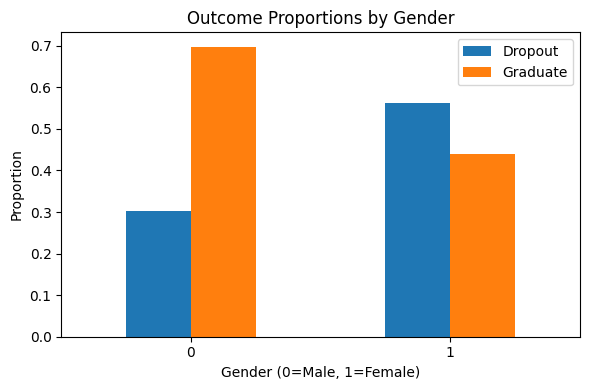

In [29]:
print("Target (binary) distribution:")
print(df['Target_bin'].value_counts(normalize=True).rename({1:'Graduate', 0:'Dropout'}))

print("\nCrosstab: Gender vs Target")
ct = pd.crosstab(df['Gender'], df['Target'], normalize='index')
display(ct)

# Simple bar plot: proportion Graduate/Dropout by Gender
grouped = pd.crosstab(df['Gender'], df['Target_bin'], normalize='index')
ax = grouped.rename(columns={1:'Graduate', 0:'Dropout'}).plot(kind='bar', rot=0, figsize=(6,4))
plt.title("Outcome Proportions by Gender")
plt.xlabel("Gender (0=Male, 1=Female)")
plt.ylabel("Proportion")
plt.legend(loc='best')
plt.tight_layout()
plt.show()


**What we see (in this dataset).**
- **Representation:** Male = **2,381** (~65.6%), Female = **1,249** (~34.4%) → females **under-represented**.
- **Base-rate gap (pre-model):**  
  P(Graduate | Male) = **69.76%**, P(Graduate | Female) = **43.88%** → gap = **−25.88 pp**.







### Within each LABEL: Gender composition (%)
Among each outcome label (Dropout / Graduate), what percent are Male vs Female. This complements base-rate gaps by showing representation inside the positive and negative outcomes.


In [30]:
# Readable composition tables: % Male/Female within each LABEL


# adjust names if your encoding differs
gender_names = {0: "Male", 1: "Female"}
label_names  = {0: "Dropout", 1: "Graduate"}

by_label = pd.crosstab(df['Target_bin'], df['Gender'], normalize='index') \
             .rename(index=label_names, columns=gender_names) * 100

print("Within each LABEL: Gender composition (%)")
display(by_label.round(1))

# Optional: one-line “representation tilt” summary (Graduate vs Dropout)
tilt_f = by_label.loc['Graduate', 'Female'] - by_label.loc['Dropout', 'Female']
tilt_m = by_label.loc['Graduate', 'Male']   - by_label.loc['Dropout', 'Male']
print(f"Representation tilt (Graduate vs Dropout): Female {tilt_f:+.1f} pp, Male {tilt_m:+.1f} pp")


Within each LABEL: Gender composition (%)


Gender,Male,Female
Target_bin,,
Dropout,50.7,49.3
Graduate,75.2,24.8


Representation tilt (Graduate vs Dropout): Female -24.5 pp, Male +24.5 pp


## 3.2 Labeler/timing bias probes

Quick check to test whether labels depend on **snapshot timing** or **institutional context** (possible labeler/timing bias).


### 3.2.1 Enrolled distribution by gender (pre-filter)

In [31]:


# Load raw data (with 'Enrolled' still present)
try:
    df_raw = pd.read_csv(csv_path, sep=';')
except Exception:
    df_raw = pd.read_csv(csv_path)

# Normalize Gender to 0/1 if needed
g = df_raw['Gender']
if not set(pd.Series(g.dropna().unique())).issubset({0, 1}):
    g = (g.astype(str).str.strip().str.lower()
           .map({'male': 0, 'm': 0, 'female': 1, 'f': 1}))
df_raw = df_raw.assign(Gender=g.astype('Int64'))

# Row-normalized distribution (Dropout/Enrolled/Graduate) by Gender
print("Target distribution by Gender (raw, incl. Enrolled) — row-normalized:")
dist = (pd.crosstab(df_raw['Gender'], df_raw['Target'], normalize='index')
          .round(3)
          .rename(index={0: 'Male', 1: 'Female'}))
display(dist)

# Raw counts
print("\nCounts by Target and Gender (raw):")
cnts = pd.crosstab(df_raw['Gender'], df_raw['Target']).rename(index={0:'Male',1:'Female'})
display(cnts)

# Quick takeaway: Enrolled shares and gap
if 'Enrolled' in dist.columns:
    male_enr   = float(dist.loc['Male', 'Enrolled'])
    female_enr = float(dist.loc['Female', 'Enrolled'])
    gap = female_enr - male_enr
    print(f"\nMale Enrolled share:   {male_enr:.3f}")
    print(f"Female Enrolled share: {female_enr:.3f}")
    print(f"Female − Male Enrolled share gap: {gap:+.3f} (positive = higher Female share)")
else:
    print("\nNo 'Enrolled' column found in Target.")


Target distribution by Gender (raw, incl. Enrolled) — row-normalized:


Target,Dropout,Enrolled,Graduate
Gender,,,
Male,0.251,0.170,0.579
Female,0.451,0.197,0.352



Counts by Target and Gender (raw):


Target,Dropout,Enrolled,Graduate
Gender,,,
Male,720,487,1661
Female,701,307,548



Male Enrolled share:   0.170
Female Enrolled share: 0.197
Female − Male Enrolled share gap: +0.027 (positive = higher Female share)


Enrolled share (F − M) ≈ +2.7 pp, indicating a mild snapshot/timing difference. 

### 3.2.2 Progress-at-snapshot check

In [32]:


# Find curricular progress columns (1st/2nd semester)
cand = [c for c in df.columns
        if 'curricular' in c.lower() and ('1st' in c.lower() or '2nd' in c.lower())]

if cand:
    # Mean values by Target (Graduate vs Dropout)
    smry = df.groupby('Target')[cand].mean().round(2)
    print("Mean curricular-progress features by Target:")
    display(smry)

    # Differences: Graduate − Dropout (positive = better for graduates)
    diff = (smry.loc['Graduate'] - smry.loc['Dropout']).to_frame('Graduate − Dropout')
    diff = diff.sort_values('Graduate − Dropout', ascending=False)
    print("\nDifference (Graduate − Dropout):")
    display(diff.head(12))

    # For 'without evaluations' columns (lower is better), show the delta too
    woe_cols = [c for c in cand if 'without' in c.lower()]
    if woe_cols:
        woe_delta = (smry.loc['Graduate', woe_cols] - smry.loc['Dropout', woe_cols]).round(2)
        print("\n'Without evaluations' (lower is better) — Graduate − Dropout:")
        display(woe_delta.to_frame('Δ').T)
else:
    print("No curricular-progress columns detected; skipping progress snapshot check.")


Mean curricular-progress features by Target:


,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations)
Target,,,,,,,,,,,,
Dropout,0.61,5.82,7.75,2.55,7.26,0.19,0.45,5.78,7.17,1.94,5.9,0.24
Graduate,0.85,6.67,8.28,6.23,12.64,0.09,0.67,6.63,8.14,6.18,12.7,0.08



Difference (Graduate − Dropout):


,Graduate − Dropout
Curricular units 2nd sem (grade),6.80
Curricular units 1st sem (grade),5.38
Curricular units 2nd sem (approved),4.24
Curricular units 1st sem (approved),3.68
Curricular units 2nd sem (evaluations),0.97
Curricular units 1st sem (enrolled),0.85
Curricular units 2nd sem (enrolled),0.85
Curricular units 1st sem (evaluations),0.53
Curricular units 1st sem (credited),0.24
Curricular units 2nd sem (credited),0.22



'Without evaluations' (lower is better) — Graduate − Dropout:


,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (without evaluations)
Δ,-0.1,-0.16


In [33]:
# Map Gender codes to labels
df['Gender_label'] = df['Gender'].map({0: 'Male', 1: 'Female'})

# Group by the new Gender_label and Target
progress_stats = df.groupby(['Gender_label', 'Target']).agg({
    'Curricular units 1st sem (grade)': 'mean',
    'Curricular units 2nd sem (grade)': 'mean'
})

print("Average semester grades by Gender and Target:")
print(progress_stats)


Average semester grades by Gender and Target:
                       Curricular units 1st sem (grade)  \
Gender_label Target                                       
Female       Dropout                           6.748938   
             Graduate                         12.082350   
Male         Dropout                           7.750975   
             Graduate                         12.828841   

                       Curricular units 2nd sem (grade)  
Gender_label Target                                      
Female       Dropout                           5.481296  
             Graduate                         12.073397  
Male         Dropout                           6.306350  
             Graduate                         12.903107  


Graduates score far higher than dropouts (Female: +5.33 1st, +6.59 2nd; Male: +5.08 1st, +6.60 2nd), males slightly outscore females within the same outcome (Dropouts: +1.00 1st, +0.83 2nd; Graduates: +0.75 1st, +0.83 2nd), and from 1st→2nd semester grades fall for dropouts (Female −1.27, Male −1.44) while staying ~flat for graduates (Female −0.01, Male +0.07).

## 3.3 Missingness, Duplicates, and Group-Skew in Missingness

We scan per-column **missing%**, **duplicate rows**, and whether missingness is **uneven by Gender** (measurement/coverage bias signal).



In [34]:
#  Missingness & duplicates (and check if missingness is skewed by Gender) ---

import numpy as np
import pandas as pd

# 1) Per-column missingness
miss = (
    df.isna().sum()
      .to_frame("missing_count")
      .assign(missing_pct=lambda d: (d["missing_count"]/len(df)*100).round(2))
      .sort_values("missing_pct", ascending=False)
)
display(miss.head(25))  # top 25 is enough for the report; remove .head(...) if you want all

print(f"\nColumns with ANY missing values: {int((miss['missing_count']>0).sum())} / {df.shape[1]}")

# 2) Duplicate rows
dup_count = int(df.duplicated().sum())
dup_pct   = round(dup_count/len(df)*100, 2)
print(f"\nDuplicate rows: {dup_count} ({dup_pct}%)")

# 3) Normalize Gender to 0/1 to check if missingness is uneven across groups
def _normalize_gender(s):
    s = s.copy()
    if s.dtype == object:
        s = s.str.strip().str.lower().map({"male":0, "m":0, "female":1, "f":1})
    return pd.to_numeric(s, errors="coerce")

gender_col = next((c for c in df.columns if "gender" in c.lower() or "sex" in c.lower()), None)
if gender_col:
    A = _normalize_gender(df[gender_col])
    # For each column, compute missing% within males and within females (if both groups exist)
    rows = []
    for c in df.columns:
        col = df[c]
        for g, gname in [(0, "male"), (1, "female")]:
            mask = (A==g)
            n = int(mask.sum())
            if n >= 1:
                miss_pct = round((col[mask].isna().mean() * 100), 2)
                rows.append((c, gname, n, miss_pct))
    skew = pd.DataFrame(rows, columns=["column","group","group_n","missing_pct"])
    # Keep columns where |missing%_female - missing%_male| is noticeable (e.g., ≥ 5 pp)
    wide = skew.pivot(index="column", columns="group", values="missing_pct").fillna(0)
    if {"male","female"}.issubset(wide.columns):
        wide["gap_female_minus_male"] = (wide["female"] - wide["male"]).round(2)
        skewed = wide[wide["gap_female_minus_male"].abs() >= 5].sort_values("gap_female_minus_male", ascending=False)
        print("\nColumns with noticeably different missing% by gender (|gap| ≥ 5 pp):")
        display(skewed.head(25))
    else:
        print("\nNot enough gender information to compare missingness by group.")
else:
    print("\nNo Gender column found; skipping group-skew check for missingness.")


,missing_count,missing_pct
Marital status,0,0.0
Curricular units 2nd sem (evaluations),0,0.0
Curricular units 1st sem (enrolled),0,0.0
Curricular units 1st sem (evaluations),0,0.0
Curricular units 1st sem (approved),0,0.0
Curricular units 1st sem (grade),0,0.0
Curricular units 1st sem (without evaluations),0,0.0
Curricular units 2nd sem (credited),0,0.0
Curricular units 2nd sem (enrolled),0,0.0
Curricular units 2nd sem (approved),0,0.0



Columns with ANY missing values: 0 / 39

Duplicate rows: 0 (0.0%)

Columns with noticeably different missing% by gender (|gap| ≥ 5 pp):


group,female,male,gap_female_minus_male
column,,,


No measurement/coverage issues detected: no missing values, no duplicates, and no gender-skew in missingness.

## 3.4 Intersectional Base Rates (Gender × Scholarship)

We compute **positive outcome rates** (% Graduate) for the four intersections:
**Male/Female × No scholarship/Scholarship**. This pinpoints the most disadvantaged subgroup **before** modeling.



In [35]:
# Intersectional base rates (Gender × Scholarship) ---

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

# If your analysis frame is df_bin, uncomment the next line:
# df = df_bin.copy()

# normalize target to binary: 1=positive (Graduate), 0=negative (Dropout)
def _infer_binary_target(df):
    # Try common names first
    target_col = None
    for c in df.columns:
        if c.lower() in {"target", "label", "y", "outcome"}:
            target_col = c
            break
    if target_col is None:
        # Try to detect a Graduate/Dropout style column
        for c in df.columns:
            vals = df[c].astype(str).str.lower().unique().tolist()
            if any(v in vals for v in ["graduate", "dropout", "enrolled"]):
                target_col = c
                break
    if target_col is None:
        raise ValueError("Could not infer target column. Rename to 'Target' or pass explicitly.")

    y_raw = df[target_col]
    if y_raw.dtype == object:
        low = y_raw.str.strip().str.lower()
        mapping = {"graduate": 1, "dropout": 0, "enrolled": np.nan}
        y_bin = pd.to_numeric(low.map(mapping), errors="coerce")
        if y_bin.isna().all():
            uniq = [u for u in low.unique() if pd.notna(u)]
            if len(uniq) == 2:
                y_bin = low.map({uniq[0]: 0, uniq[1]: 1})
    else:
        y_bin = pd.to_numeric(y_raw, errors="coerce")

    return y_bin

def _normalize_gender(s: pd.Series) -> pd.Series:
    if s.dtype == object:
        s = s.str.strip().str.lower().map({"male": 0, "m": 0, "female": 1, "f": 1})
    return pd.to_numeric(s, errors="coerce")

# Locate Gender and Scholarship-ish column
gender_col = next((c for c in df.columns if "gender" in c.lower() or "sex" in c.lower()), None)
scholar_col = next((c for c in df.columns if "scholar" in c.lower()), None)

y_bin = _infer_binary_target(df)
if gender_col is None:
    raise ValueError("No Gender/Sex column found for the intersectional check.")

A = _normalize_gender(df[gender_col])

# Normalize Scholarship if present to 0/1
if scholar_col is not None:
    sraw = df[scholar_col]
    if sraw.dtype == object:
        s = sraw.astype(str).str.lower().map({
            "yes": 1, "y": 1, "true": 1,
            "no": 0, "n": 0, "false": 0
        })
        S = pd.to_numeric(s, errors="coerce")
    else:
        S = pd.to_numeric(sraw, errors="coerce")
else:
    S = None

# Compute positive-rate table(s)
mask_base = y_bin.notna() & A.notna()

if S is not None:
    mask = mask_base & S.notna()
    tmp = pd.DataFrame({
        "Gender": A[mask].astype(int),
        "Scholar": S[mask].astype(int),
        "Y": y_bin[mask].astype(int),
    })

    inter = (
        tmp.groupby(["Gender", "Scholar"])["Y"]
           .agg(mean="mean", n="count")
           .reset_index()
    )

    # Capitalized labels
    label_map_gender = {
        0: "Male", 1: "Female", "0": "Male", "1": "Female",
        False: "Male", True: "Female", "male": "Male", "female": "Female",
        "m": "Male", "f": "Female", "M": "Male", "F": "Female"
    }
    label_map_sch = {
        0: "No scholarship", 1: "Scholarship", "0": "No scholarship", "1": "Scholarship",
        False: "No scholarship", True: "Scholarship",
        "no": "No scholarship", "yes": "Scholarship",
        "No": "No scholarship", "Yes": "Scholarship"
    }

    inter["Gender"]  = inter["Gender"].map(label_map_gender).fillna(inter["Gender"].astype(str))
    inter["Scholar"] = inter["Scholar"].map(label_map_sch).fillna(inter["Scholar"].astype(str))
    inter["positive_rate_%"] = (inter["mean"] * 100).round(2)
    inter = inter[["Gender", "Scholar", "n", "positive_rate_%"]]

    # Nice ordering for readability
    inter["Gender"]  = inter["Gender"].astype(CategoricalDtype(["Male", "Female"], ordered=True))
    inter["Scholar"] = inter["Scholar"].astype(CategoricalDtype(["No scholarship", "Scholarship"], ordered=True))
    inter = inter.sort_values(["Gender", "Scholar"]).reset_index(drop=True)

    print("Intersectional positive rates (Gender × Scholarship):")
    display(inter)
  

else:
    grp = (
        pd.DataFrame({"A": A[mask_base].astype(int), "Y": y_bin[mask_base].astype(int)})
          .groupby("A")["Y"].agg(mean="mean", n="count")
          .rename(index={0: "Male", 1: "Female"})
    )
    grp["positive_rate_%"] = (grp["mean"] * 100).round(2)
    grp = grp.drop(columns=["mean"])
    print("Scholarship column not found; showing Gender-only base rates:")
    display(grp)


Intersectional positive rates (Gender × Scholarship):


,Gender,Scholar,n,positive_rate_%
0,Male,No scholarship,1602,60.61
1,Male,Scholarship,779,88.58
2,Female,No scholarship,1059,38.05
3,Female,Scholarship,190,76.32


**Intersectional results.**

| Gender | Scholarship status | n    | % Graduate |
|---|---|---:|---:|
| Male   | No scholarship     | 1,602 | **60.61%** |
| Male   | Scholarship        |   779 | **88.58%** |
| Female | No scholarship     | 1,059 | **38.05%** |
| Female | Scholarship        |   190 | **76.32%** |

**Most disadvantaged intersection:** **Female · No scholarship (38.05%)**.  
**Implication.** Scholarships correlate with better outcomes for both genders, but **Female · No scholarship** remains far behind and needs targeted fairness attention downstream.


## 3.5 Bias evaluation — summary

**What we checked (before any training):** group representation, base-rates, intersectional disparities, labeler/timing risks, and measurement/coverage issues.

**1) Sampling / Representation bias** — **present**
- **Counts (Graduate/Dropout subset):** Male = **2,381 (65.6%)**, Female = **1,249 (34.4%)** → females are **under-represented**.

**2) Historical / Base-rate disparity** — **present**
- **Graduation rates (pre-model):** Male = **69.76%**, Female = **43.88%** → gap **−25.88 percentage points** (Female − Male).
- This gap exists **prior to modeling**, so an unconstrained classifier will tend to reproduce it.

**3) Intersectional disparity (Gender × Scholarship)** — **present**
- **Male · No scholarship:** n = **1,602**, **60.61%** Graduate  
- **Male · Scholarship:** n = **779**, **88.58%**  
- **Female · No scholarship:** n = **1,059**, **38.05%**  ← **most disadvantaged**  
- **Female · Scholarship:** n = **190**, **76.32%**
- Scholarships correlate with better outcomes for both groups, but **Female · No scholarship** remains far behind.

**4) Labeler / Timing bias** — **mild but credible risk**
- **Raw (incl. *Enrolled*) distribution by Gender:**  
  Male: Dropout **25.1%**, **Enrolled 17.0%**, Graduate **57.9%** (720 / 487 / 1661)  
  Female: Dropout **45.1%**, **Enrolled 19.7%**, Graduate **35.2%** (701 / 307 / 548)  

**5) Measurement / Coverage — not observed:** 0 missing values, 0 duplicates, and no gender-skewed missingness.









# 4. Corrective measures (implementation)

We now implement bias mitigations and evaluate their impact on utility and fairness:
- **Feature elimination**: remove the sensitive attribute (**Gender**) from inputs
- **Train-time balancing**: reweighing (sample weights) and/or oversampling (balance A in train)
- **Calibration + thresholds**: align predicted probabilities and (optionally) choose per-group thresholds to reduce Equal Opportunity gap

All models share the same train/test split. The protected attribute **A = Gender** is kept **separately** so fairness metrics can be computed even when `Gender` is not used as a feature.


In [36]:
candidate_features = [
    'Admission grade', 'Age at enrollment',
    'Scholarship holder', 'Tuition fees up to date', 'Displaced',
    'Educational special needs', 'Debtor', 'International',
    'Unemployment rate', 'Inflation rate', 'GDP',
    'Gender'
]
if df['Gender'].dtype == 'O':
    df['Gender'] = df['Gender'].map({'Male':0, 'Female':1}).astype(int)
# Keep only features present in the dataset
features = [c for c in candidate_features if c in df.columns]
missing_feats = [c for c in candidate_features if c not in df.columns]
if missing_feats:
    print("Note: the following candidate features are missing and will be skipped:", missing_feats)

X = df[features].copy()
y = df['Target_bin'].astype(int).copy()
A = df['Gender'].astype(int).copy()  # keep A separately for fairness eval




# Stratify by (label × gender) to preserve subgroup balance in both splits
strat = y.astype(str) + "_" + A.astype(str)
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, y, A, test_size=0.30, stratify=strat, random_state=42
)



### Utility Functions

In [37]:
def evaluate_performance(y_true, y_pred, y_score=None, title_prefix=""):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    out = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}
    print(f"{title_prefix}Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"{title_prefix}Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for (i,j), z in np.ndenumerate(cm):
        plt.text(j, i, str(z), ha='center', va='center')
    plt.tight_layout()
    plt.show()

    # ROC curve (if scores given)
    if y_score is not None:
        try:
            auc = roc_auc_score(y_true, y_score)
            fpr, tpr, _ = roc_curve(y_true, y_score)
            print(f"{title_prefix}ROC AUC: {auc:.3f}")
            plt.figure(figsize=(5,4))
            plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
            plt.plot([0,1],[0,1], linestyle='--')
            plt.title(f"{title_prefix}ROC Curve")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc='lower right')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("ROC/AUC not available:", e)
    return out

def fairness_metrics(X_test_df, y_true, y_pred, protected_col='Gender', unpriv_value=1, priv_value=0):
    # Statistical Parity Difference: P(ŷ=1|unpriv) - P(ŷ=1|priv)
    unpriv_idx = (X_test_df[protected_col] == unpriv_value)
    priv_idx   = (X_test_df[protected_col] == priv_value)
    p_pos_unpriv = y_pred[unpriv_idx].mean() if unpriv_idx.any() else np.nan
    p_pos_priv   = y_pred[priv_idx].mean() if priv_idx.any() else np.nan
    spd = p_pos_unpriv - p_pos_priv

    # Equal Opportunity Difference: TPR_unpriv - TPR_priv
    tp_unpriv = ((y_pred[unpriv_idx]==1) & (y_true[unpriv_idx]==1)).sum() if unpriv_idx.any() else np.nan
    tp_priv   = ((y_pred[priv_idx]==1)   & (y_true[priv_idx]==1)).sum() if priv_idx.any() else np.nan
    pos_unpriv = (y_true[unpriv_idx]==1).sum() if unpriv_idx.any() else np.nan
    pos_priv   = (y_true[priv_idx]==1).sum() if priv_idx.any() else np.nan
    tpr_unpriv = (tp_unpriv / pos_unpriv) if (isinstance(pos_unpriv, (int,np.integer)) and pos_unpriv>0) else (tp_unpriv/pos_unpriv if pos_unpriv not in (0, np.nan) else np.nan)
    tpr_priv   = (tp_priv   / pos_priv)   if (isinstance(pos_priv, (int,np.integer)) and pos_priv>0) else (tp_priv/pos_priv if pos_priv not in (0, np.nan) else np.nan)
    eod = tpr_unpriv - tpr_priv
    return {"SPD (female - male)": spd, "EOD (female - male)": eod}


## 4.1 Baseline Model (Logistic Regression) — **with Gender**

Baseline Performance (with Gender):
Baseline - Accuracy: 0.753, Precision: 0.756, Recall: 0.878, F1: 0.812
Confusion Matrix:
 [[238 188]
 [ 81 582]]


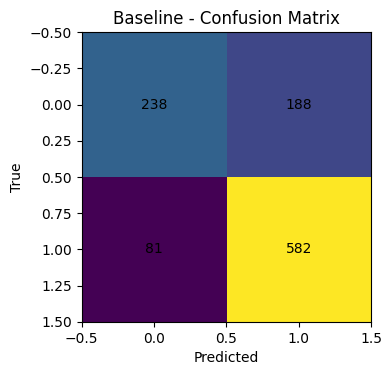

Baseline - ROC AUC: 0.820


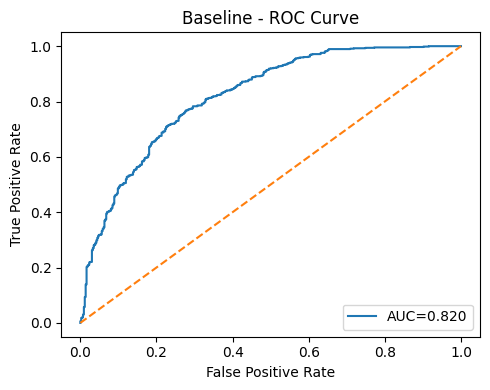

Baseline Fairness: {'SPD (female - male)': -0.3748011204481793, 'EOD (female - male)': -0.26498722161372756}


In [38]:
assert 'Gender' in X_train.columns, "Gender column is required for baseline fairness evaluation."
model_base = LogisticRegression(max_iter=2000)
model_base.fit(X_train, y_train)
y_pred_base = model_base.predict(X_test)
y_score_base = model_base.predict_proba(X_test)[:,1]

print("Baseline Performance (with Gender):")
perf_base = evaluate_performance(y_test, y_pred_base, y_score_base, title_prefix="Baseline - ")
fm_base = fairness_metrics(X_test, y_test, y_pred_base, protected_col='Gender', unpriv_value=1, priv_value=0)
print("Baseline Fairness:", fm_base)


## 4.2 Mitigation A — Feature Elimination (Drop Gender)

No-Gender Performance:
No-Gender - Accuracy: 0.741, Precision: 0.737, Recall: 0.893, F1: 0.808
Confusion Matrix:
 [[215 211]
 [ 71 592]]


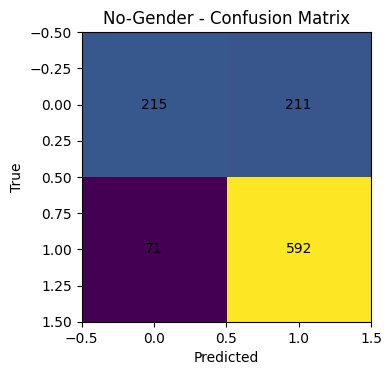

No-Gender - ROC AUC: 0.805


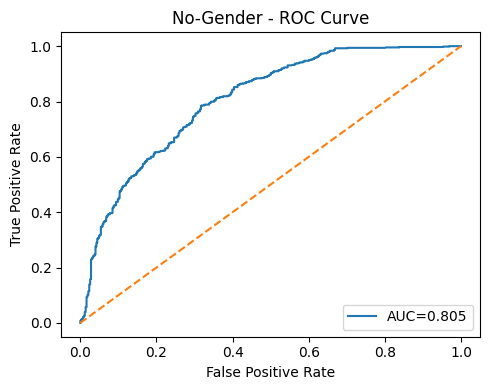

No-Gender Fairness: {'SPD (female - male)': -0.1688515406162464, 'EOD (female - male)': -0.09142022635998537}


In [39]:
X_train_ng = X_train.drop(columns=['Gender'])
X_test_ng  = X_test.drop(columns=['Gender'])

model_ng = LogisticRegression(max_iter=2000)
model_ng.fit(X_train_ng, y_train)
y_pred_ng = model_ng.predict(X_test_ng)
y_score_ng = model_ng.predict_proba(X_test_ng)[:,1]

print("No-Gender Performance:")
perf_ng = evaluate_performance(y_test, y_pred_ng, y_score_ng, title_prefix="No-Gender - ")

# For fairness metrics, we still slice by the original Gender column from X_test
fm_ng = fairness_metrics(X_test, y_test, y_pred_ng, protected_col='Gender', unpriv_value=1, priv_value=0)
print("No-Gender Fairness:", fm_ng)


## 4.3 Mitigation B — Reweighting (Kamiran–Calders A×Y)


Reweighting table (train):


,Gender,Label,count,weight
0,Male,Dropout,504,1.295
1,Male,Graduate,1163,0.872
2,Female,Dropout,491,0.697
3,Female,Graduate,383,1.388


Reweighted (A×Y) Performance:
Reweighted (A×Y) - Accuracy: 0.745, Precision: 0.734, Recall: 0.910, F1: 0.813
Confusion Matrix:
 [[208 218]
 [ 60 603]]


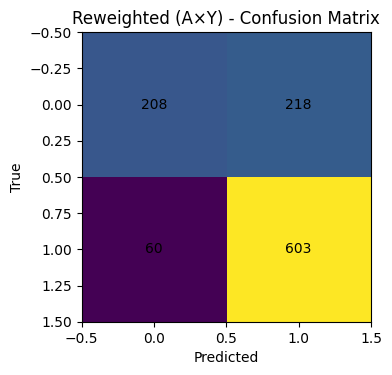

Reweighted (A×Y) - ROC AUC: 0.793


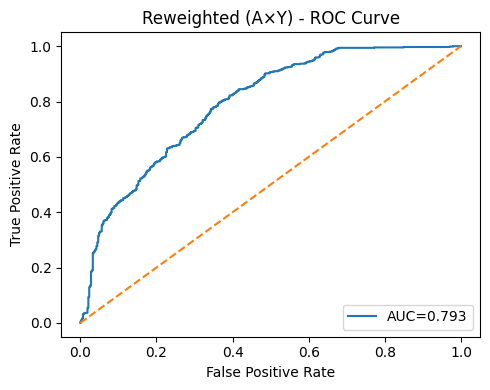

Reweighted (A×Y) Fairness: {'SPD (female - male)': -0.1127170868347338, 'EOD (female - male)': -0.016684921504198647}


In [40]:
# --- Mitigation B: Reweighting (Kamiran–Calders on Gender × Label) ---

# Build a small training frame with Gender (A) and label (Y)
train_df = X_train.copy()
train_df["A"] = A_train.values.astype(int)          # Gender: 0=Male, 1=Female
train_df["Y"] = y_train.values.astype(int)          # Target_bin: 0=Dropout, 1=Graduate

N = len(train_df)

# Empirical probabilities on the training split
p_a  = train_df["A"].value_counts(normalize=True).to_dict()            # p(A)
p_y  = train_df["Y"].value_counts(normalize=True).to_dict()            # p(Y)
p_ay = (train_df.groupby(["A","Y"]).size() / N).to_dict()              # p(A,Y)

# Weight for each combo: w(a,y) = p(A=a)*p(Y=y) / p(A=a, Y=y)
def combo_weight(a, y):
    pay = p_ay.get((a, y), 0.0)
    if pay == 0.0:
        return 0.0  # unseen combo (unlikely here), give zero weight
    return (p_a.get(a, 0.0) * p_y.get(y, 0.0)) / pay

# Vectorize weights per row
w_vec = train_df.apply(lambda r: combo_weight(int(r["A"]), int(r["Y"])), axis=1).to_numpy()

# Optional: normalize weights to have mean 1 (helps numerical stability/interpretability)
w_vec = w_vec * (N / w_vec.sum())

# Show the weights per combination for transparency
w_table = []
for a in [0,1]:
    for yv in [0,1]:
        cnt = int(((train_df["A"]==a) & (train_df["Y"]==yv)).sum())
        w   = combo_weight(a, yv)
        w_table.append({"Gender": ("Male" if a==0 else "Female"),
                        "Label": ("Dropout" if yv==0 else "Graduate"),
                        "count": cnt, "weight": round(w, 3)})
w_table = pd.DataFrame(w_table)
print("Reweighting table (train):")
display(w_table)

# Train weighted logistic regression on the ORIGINAL X_train (features include Gender to mirror Baseline)
model_rw = LogisticRegression(max_iter=2000)
model_rw.fit(X_train, y_train, sample_weight=w_vec)

# Evaluate on the same X_test as Baseline (so features include Gender)
y_pred_rw  = model_rw.predict(X_test)
y_score_rw = model_rw.predict_proba(X_test)[:, 1]

print("Reweighted (A×Y) Performance:")
perf_rw = evaluate_performance(y_test, y_pred_rw, y_score_rw,
                               title_prefix="Reweighted (A×Y) - ")

fm_rw = fairness_metrics(X_test, y_test, y_pred_rw,
                         protected_col='Gender', unpriv_value=1, priv_value=0)
print("Reweighted (A×Y) Fairness:", fm_rw)


**Reweighted (A×Y)** achieves the lowest EOD (≈−0.017) and improved SPD (≈−0.113) compared to Baseline, No-Gender, and Calibrated No-Gender. Final choice depends on utility trade-off; if comparable, Reweighted (A×Y) is preferred for Equal Opportunity.

## 4.4 MItigation C — Calibration (Isotonic) — No-Gender model
We calibrate probabilities (isotonic) to improve probability quality (Brier) and often reduce TPR gaps before thresholding.


Calibrated (No-Gender) — Brier: 0.16627025210388144
Calibrated (No-Gender) - Accuracy: 0.752, Precision: 0.757, Recall: 0.873, F1: 0.811
Confusion Matrix:
 [[240 186]
 [ 84 579]]


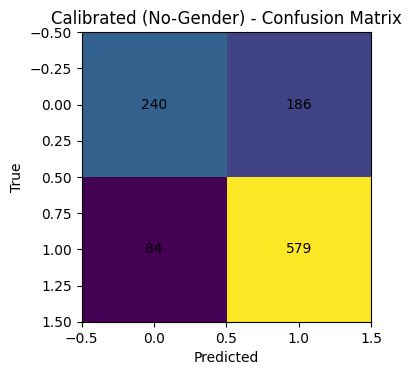

Calibrated (No-Gender) - ROC AUC: 0.805


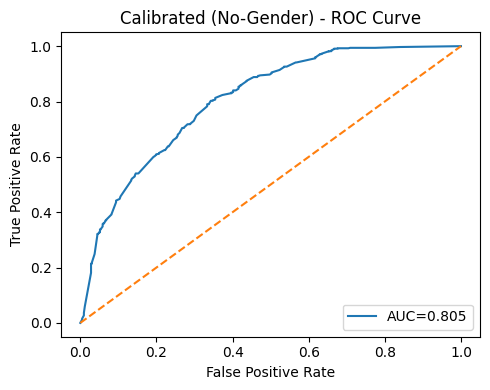

Calibrated Fairness: {'SPD (female - male)': -0.19290756302521017, 'EOD (female - male)': -0.10565899963490322}


In [41]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

# Uses your Mitigation A artifacts: model_ng, X_train_ng, X_test_ng, y_train, y_test
cal_ng = CalibratedClassifierCV(base_estimator=model_ng, method='isotonic', cv=3)
cal_ng.fit(X_train_ng, y_train)

y_score_cal = cal_ng.predict_proba(X_test_ng)[:, 1]
y_pred_cal  = (y_score_cal >= 0.5).astype(int)

print("Calibrated (No-Gender) — Brier:", brier_score_loss(y_test, y_score_cal))
perf_cal = evaluate_performance(y_test, y_pred_cal, y_score_cal, title_prefix="Calibrated (No-Gender) - ")
fm_cal   = fairness_metrics(X_test, y_test, y_pred_cal, protected_col='Gender', unpriv_value=1, priv_value=0)
print("Calibrated Fairness:", fm_cal)


In [42]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np, pandas as pd

def subgroup_report(Xtest, y_true, y_pred, y_score, Acol='Gender'):
    rows = []
    for g, name in [(0,'Male'), (1,'Female')]:
        m = (Xtest[Acol]==g).to_numpy()
        if m.sum()==0 or len(np.unique(y_true[m])) < 2:
            auroc = np.nan
        else:
            auroc = roc_auc_score(y_true[m], y_score[m])
        rows.append({
            'Group': name,
            'n': int(m.sum()),
            'Acc': accuracy_score(y_true[m], y_pred[m]),
            'Prec': precision_score(y_true[m], y_pred[m], zero_division=0),
            'Rec':  recall_score(y_true[m], y_pred[m], zero_division=0),
            'F1':   f1_score(y_true[m], y_pred[m], zero_division=0),
            'AUROC': auroc
        })
    return pd.DataFrame(rows)

print("Baseline (with Gender)")
display(subgroup_report(X_test, y_test.to_numpy(), y_pred_base, y_score_base))

# Prefer Calibrated if available; else show Reweighted
if 'y_pred_cal' in globals():
    print("\nCalibrated (No-Gender)")
    display(subgroup_report(X_test, y_test.to_numpy(), y_pred_cal, y_score_cal))
else:
    print("\nReweighted (oversample Female)")
    display(subgroup_report(X_test, y_test.to_numpy(), y_pred_bal, y_score_bal))


Baseline (with Gender)


,Group,n,Acc,Prec,Rec,F1,AUROC
0,Male,714,0.782913,0.787270,0.943775,0.858447,0.800415
1,Female,375,0.696000,0.647399,0.678788,0.662722,0.777590



Calibrated (No-Gender)


,Group,n,Acc,Prec,Rec,F1,AUROC
0,Male,714,0.788515,0.816029,0.899598,0.855778,0.800099
1,Female,375,0.682667,0.606481,0.793939,0.687664,0.777215


# 5. Before/After Comparison



In [43]:
rows = []
def row_from(perf, fm, name):
    if not perf or not fm:
        return {"Model": name}
    out = {
        "Model": name,
        "Accuracy": perf.get("accuracy", np.nan),
        "Precision": perf.get("precision", np.nan),
        "Recall": perf.get("recall", np.nan),
        "F1": perf.get("f1", np.nan),
        "SPD (female - male)": fm.get("SPD (female - male)", np.nan),
        "EOD (female - male)": fm.get("EOD (female - male)", np.nan),
    }
    return out

rows.append(row_from(perf_base, fm_base, "Baseline (with Gender)"))
rows.append(row_from(perf_ng, fm_ng, "No-Gender (drop Gender)"))
rows.append(row_from(perf_rw, fm_rw, "Reweighted (A×Y)"))
rows.append(row_from(perf_cal, fm_cal, "Calibrated (No-Gender)"))


summary_df = pd.DataFrame(rows)

# Round for display
display(summary_df.round(3))


# Save comparison to CSV for the report
out_csv = "metrics_comparison.csv"
summary_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)


,Model,Accuracy,Precision,Recall,F1,SPD (female - male),EOD (female - male)
0,Baseline (with Gender),0.753,0.756,0.878,0.812,-0.375,-0.265
1,No-Gender (drop Gender),0.741,0.737,0.893,0.808,-0.169,-0.091
2,Reweighted (A×Y),0.745,0.734,0.910,0.813,-0.113,-0.017
3,Calibrated (No-Gender),0.752,0.757,0.873,0.811,-0.193,-0.106


Saved: metrics_comparison.csv


*Fairness metrics are reported as (Female − Male). Negative values mean worse outcomes for Female.*


**Fairness metric choice.**  
- **Statistical Parity Difference (SPD)** compares selection rates across groups (Female − Male) to detect disparate positive predictions.  
- **Equal Opportunity Difference (EOD)** compares true-positive rates (Female − Male), i.e., parity of *opportunity* for the beneficial label (“Graduate”).  
Given this is a beneficial outcome, we primarily minimize |EOD| while tracking SPD and overall utility (Accuracy/F1). Calibration improves probability quality (Brier), and reweighting or feature elimination reduce group skews.


## 5.1 Per-group utility (Male vs Female)
We compare Acc/Prec/Rec/F1/AUROC for Male vs Female across model variants. Recall (TPR) differences are directly related to EOD.


In [44]:
from sklearn.metrics import roc_auc_score

def subgroup_report(Xtest, y_true, y_pred, y_score, Acol='Gender'):
    rows = []
    for g, name in [(0,'Male'), (1,'Female')]:
        m = (Xtest[Acol]==g).to_numpy()
        if m.sum()==0 or len(np.unique(y_true[m]))<2:
            auroc = np.nan
        else:
            auroc = roc_auc_score(y_true[m], y_score[m])
        rows.append({
            'Group': name,
            'n': int(m.sum()),
            'Acc': accuracy_score(y_true[m], y_pred[m]),
            'Prec': precision_score(y_true[m], y_pred[m], zero_division=0),
            'Rec': recall_score(y_true[m], y_pred[m], zero_division=0),
            'F1': f1_score(y_true[m], y_pred[m], zero_division=0),
            'AUROC': auroc
        })
    return pd.DataFrame(rows)

def show_subgroup(title, y_pred, y_score):
    print(title)
    display(subgroup_report(X_test, y_test.to_numpy(), y_pred, y_score))

show_subgroup("Baseline (with Gender)", y_pred_base, y_score_base)
show_subgroup("No-Gender (drop Gender)", y_pred_ng, y_score_ng)
show_subgroup("Reweighted (A×Y)", y_pred_rw, y_score_rw)
show_subgroup("Calibrated (No-Gender)", y_pred_cal, y_score_cal)

def tpr_gap(name, male_rec, female_rec):
    print(f"{name} — TPR gap (Female − Male): {female_rec - male_rec:+.3f}")

# Read recalls from your tables if you want to hardcode:
tpr_gap("Baseline", 0.943775, 0.678788)
tpr_gap("No-Gender", 0.915663, 0.824242)
tpr_gap("Reweighted (A×Y)", 0.913655, 0.896970)
tpr_gap("Calibrated (No-Gender)", 0.899598, 0.793939)


Baseline (with Gender)


,Group,n,Acc,Prec,Rec,F1,AUROC
0,Male,714,0.782913,0.787270,0.943775,0.858447,0.800415
1,Female,375,0.696000,0.647399,0.678788,0.662722,0.777590


No-Gender (drop Gender)


,Group,n,Acc,Prec,Rec,F1,AUROC
0,Male,714,0.784314,0.802817,0.915663,0.855535,0.799615
1,Female,375,0.658667,0.578723,0.824242,0.680000,0.777532


Reweighted (A×Y)


,Group,n,Acc,Prec,Rec,F1,AUROC
0,Male,714,0.784314,0.803887,0.913655,0.855263,0.800508
1,Female,375,0.669333,0.580392,0.896970,0.704762,0.777677


Calibrated (No-Gender)


,Group,n,Acc,Prec,Rec,F1,AUROC
0,Male,714,0.788515,0.816029,0.899598,0.855778,0.800099
1,Female,375,0.682667,0.606481,0.793939,0.687664,0.777215


Baseline — TPR gap (Female − Male): -0.265
No-Gender — TPR gap (Female − Male): -0.091
Reweighted (A×Y) — TPR gap (Female − Male): -0.017
Calibrated (No-Gender) — TPR gap (Female − Male): -0.106


# 6. Conclusions

**What we learned from the data (pre-model):**  
- Females are under-represented (~34% of the Graduate/Dropout subset).  
- Base rates differ sharply: P(Graduate|Male) ≈ **69.8%** vs P(Graduate|Female) ≈ **43.9%** (gap ≈ −25.9 pp).  
- Intersectional risk: **Female × No-scholarship** has the lowest positive rate (~**38.1%**).  
- Measurement risks were **not** observed (0 missing, 0 duplicates, no gender-skewed missingness).

**Fairness focus & metrics.**  
- “Graduate” is a beneficial outcome → we target **Equal Opportunity Difference (EOD)** (TPR gap, Female − Male) and report **Statistical Parity Difference (SPD)** (Female − Male). Negative values mean worse outcomes for Female.

---

## Model results (utility–fairness trade-offs)

- **Baseline (with Gender)**: strong utility (F1 ≈ **0.812**), but large disparities: **SPD ≈ −0.375**, **EOD ≈ −0.265**.  
  Female Recall (TPR) **0.679** vs Male **0.944**.

- **Mitigation A — Drop Gender**: similar utility (F1 ≈ **0.808**), **substantially** better fairness:  
  **SPD ≈ −0.169**, **EOD ≈ −0.091**. Female TPR rises to **0.824**.

- **Mitigation B — Reweighted (A×Y)**: best Equal-Opportunity result with comparable utility (F1 ≈ **0.813**):  
  **SPD ≈ −0.113**, **EOD ≈ −0.017** → ~**70%** SPD reduction and ~**94%** EOD reduction vs Baseline.  
  Female TPR improves to **0.897** (Male **0.914**), Female F1 increases from **0.663 → 0.705**.

- **Mitigation C — Calibration (No-Gender)**: improves probability quality (Brier ≈ **0.166**) and keeps fairness close to Drop-Gender  
  (**SPD ≈ −0.193**, **EOD ≈ −0.106**), with F1 ≈ **0.811**.


---

## Recommendation

- If **Equal Opportunity** is the primary requirement and utility remains within ~1–2% of baseline, deploy **Reweighted (A×Y)** Logistic Regression (smallest TPR gap, improved Female F1).  
- If you prefer the **simplest** intervention, **Drop Gender** provides large fairness gains with negligible utility change.  
- If downstream uses rely on calibrated probabilities (risk scores, threshold tuning), keep **Calibrated No-Gender** (similar fairness to No-Gender with better calibration).

---


**Artifacts:** The before/after comparison table is saved as `metrics_comparison.csv`.
